## Import Dataset

In [1]:
!gdown --id 1tgpOBLRzo3NEXUa2pE_pSLJvQk7lDizj

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tgpOBLRzo3NEXUa2pE_pSLJvQk7lDizj
To: /content/cats_and_dogs_filtered.zip
100% 68.6M/68.6M [00:01<00:00, 64.4MB/s]


In [3]:
import os
import zipfile

# Unzip dataset yang masih berbentuk file zip
zip_ref = zipfile.ZipFile("./smoker_detection.zip", 'r')
zip_ref.extractall("./")
zip_ref.close()

In [9]:
# Menentukan path dari dataset untuk training dan dataset untuk validasi
training_dir = '/content/smoker_detection/Training'
validation_dir = '/content/smoker_detection/Validation'

training_data_notsmoking = os.listdir(training_dir + '/notsmoking/')
training_data_smoking = os.listdir(training_dir + '/smoking/')

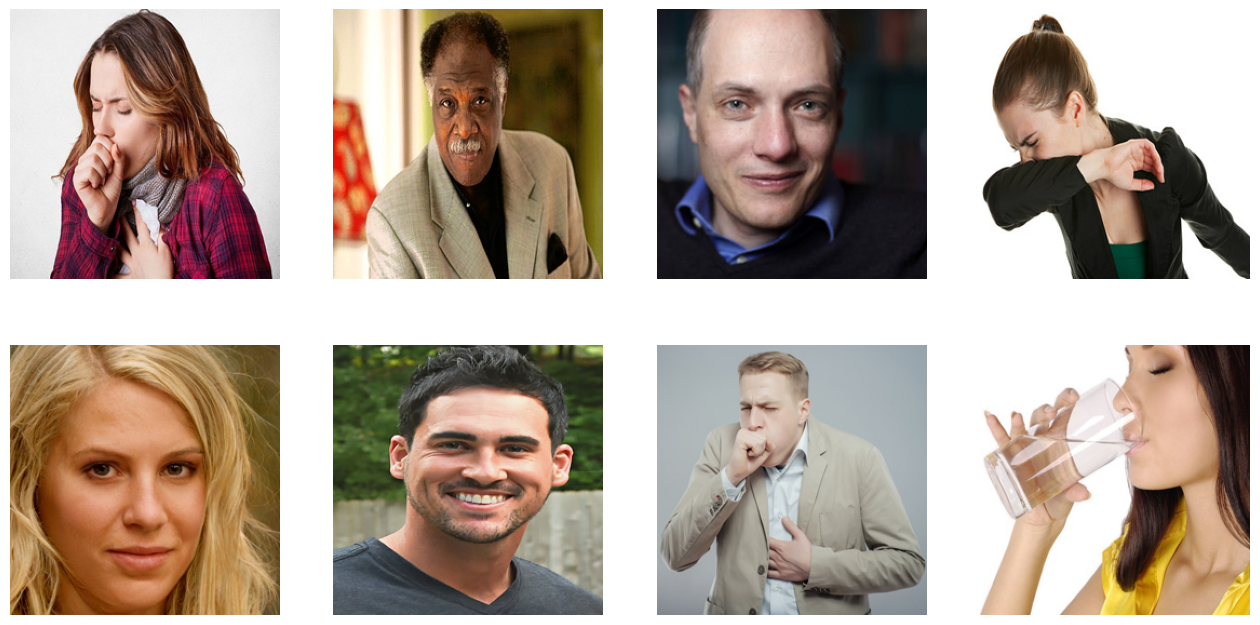

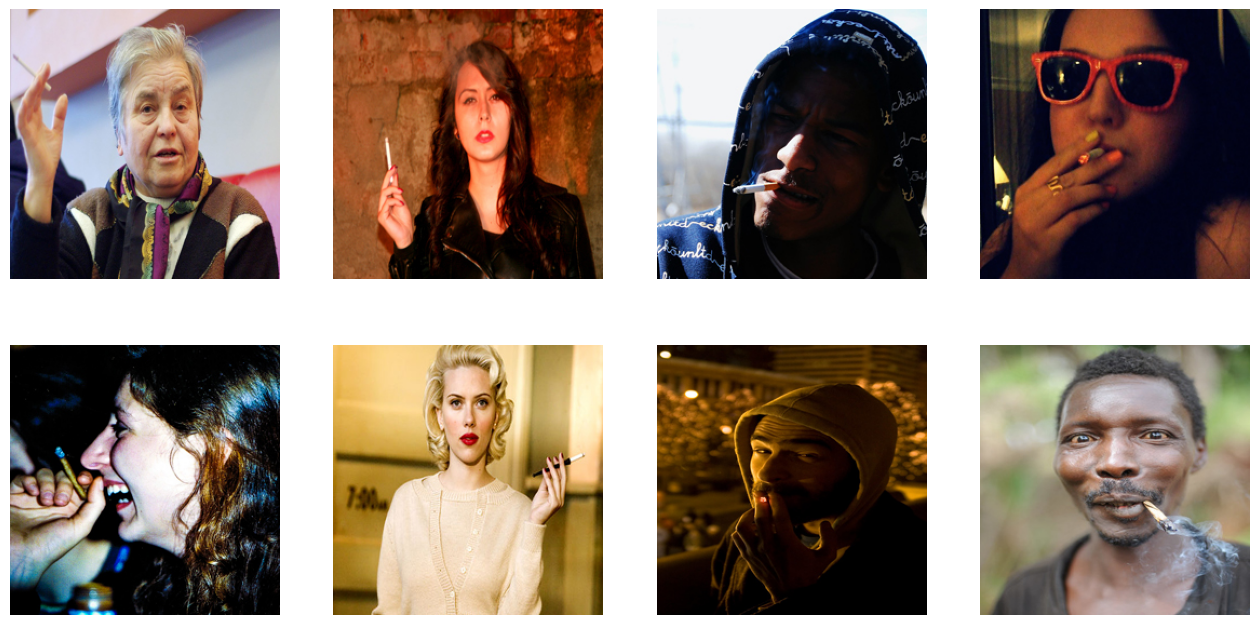

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameter grafik yangakan digunakan untuk menampilkan gambar menggunakan konfigurasi 4x4
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 2)

next_notsmoking_pic = training_data_notsmoking[:8]
next_smoking_pic = training_data_smoking[:8]

for i, img_path in enumerate(next_notsmoking_pic):
  # Menyiapkan subplot; indeks subplot dimulai dari 1
  sp = plt.subplot(2, 4, i + 1)
  sp.axis('Off') # Jangan tampilkan sumbu (atau garis kisi)

  img = mpimg.imread(training_dir + '/notsmoking/' + img_path)
  plt.imshow(img)
plt.show()

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 2)

for i, img_path in enumerate(next_smoking_pic):
  # Menyiapkan subplot; indeks subplot dimulai dari 1
  sp = plt.subplot(2, 4, i + 1)
  sp.axis('Off') # Jangan tampilkan sumbu (atau garis kisi)

  img = mpimg.imread(training_dir + '/smoking/' + img_path)
  plt.imshow(img)
plt.show()

## Pre-processing

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Melakukan image augmentation pada dataset untuk menambah variasi data
training_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,)
                                   #dtype=tf.float32

testing_datagen = ImageDataGenerator( rescale = 1.0/255.,)
                                   #dtype=tf.float32)

# Melakukan data generator untuk membaca dataset training di setiap label
training_generator = training_datagen.flow_from_directory(training_dir,
                                                    batch_size = 32,
                                                    class_mode = 'binary',
                                                    target_size = (224, 224))

# Melakukan data generator untuk membaca dataset testing di setiap label
validation_generator =  testing_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 32,
                                                          class_mode  = 'binary',
                                                          target_size = (224, 224))

Found 716 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


## Modeling

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

In [13]:
#@title Pilih Pretrained Model :  { display-mode: "both" }
Model = "MobileNet" #@param ["VGG16", "MobileNet", "InceptionNet", "ResNet"]

# Pilihan pretrained model yang dapat digunakan di sesi ini
if Model == "VGG16":
  base_model = VGG16(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet')

elif Model == "ResNet50":
  base_model = ResNet50(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet')

elif Model == "MobileNet":
  base_model = MobileNet(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet')

else:
  base_model = InceptionV3(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet'
)

print("Model yang akan digunakan : ", Model)

# Membuat base model tidak diikutkan proses training
for layer in base_model.layers:
  layer.trainable = False

17225924/17225924 [==============================] - 2s 0us/step
Model yang akan digunakan :  MobileNet


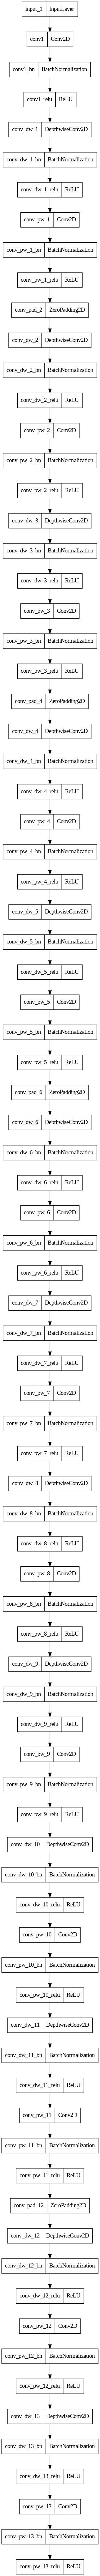

In [14]:
# Membuat visualisasi plot arsitektur yang telah kita pilih
plot_model(base_model, to_file='my_base_model.png')

In [15]:
# Menggunakan .summary() untuk menampilkan arsitektur yang digunakan
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [16]:
import tensorflow as tf


x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.15)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [19]:
history = model.fit(training_generator, validation_data=validation_generator,
                    steps_per_epoch = 60, epochs = 10)

Epoch 1/10
23/60 [==========>...................] - ETA: 17s - loss: 0.6217 - accuracy: 0.6704

60/60 [==============================] - 28s 212ms/step - loss: 0.6217 - accuracy: 0.6704 - val_loss: 0.5144 - val_accuracy: 0.7222


## Evaluasi

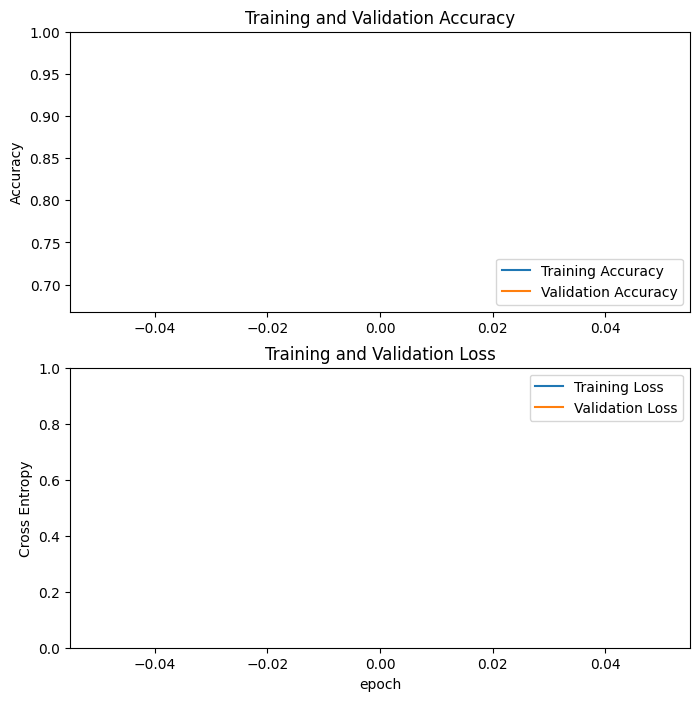

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

6/6 [==============================] - 1s 84ms/step


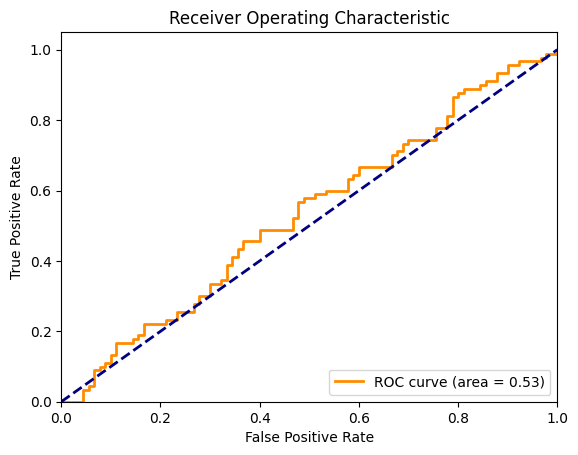

In [23]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

preds = model.predict(validation_generator, verbose=1)
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Test Gambar

Saving mustain.jpg to mustain.jpg


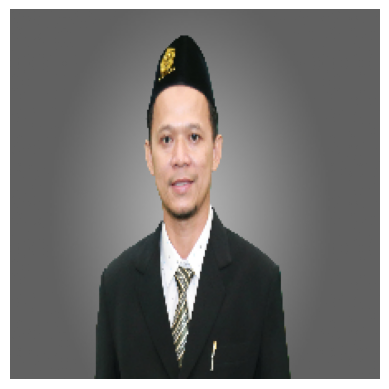

1/1 [==============================] - 0s 24ms/step

 ini adalah gambar orang yang tidak merokok (not smoking)


In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)

  plt.imshow(x/255.)
  plt.axis('off')
  plt.show()

  x = np.expand_dims(x, axis=0)
  # images = np.vstack([x])

  classes = model.predict(x)

  if classes[0]<0.5:
    print("\n ini adalah gambar orang yang tidak merokok (not smoking)")
  else:
    print("\n ini adalah gambar orang yang sedang merokok (smoking)")